# Process Spatio-Spectral Images

##### Script to write to Gwyddion compatible export, no user input necessary

In [6]:
import array, sys, math

def write_gsf(filename, imagedata, xres, yres,
              xreal=None, yreal=None, xyunits=None, zunits=None, title=None):
    """Write a Gwyddion GSF file.

    filename -- Name of the output file.
    imagedata -- Image data.
    xres -- Horizontal image resolution.
    yres -- Vertical image resolution.
    xreal -- Horizontal physical dimension (optional).
    yreal -- Vertical physical dimension (optional).
    xyunits -- Unit of physical dimensions (optional).
    zunits -- Unit of values (optional).
    title -- Image title (optional).

    Image data may be passed as any listable object that can be used to form
    a floating point array.array().  This includes tuples, lists, arrays,
    numpy arrays and other stuff.
    """
    data = array.array('f', imagedata)
    if len(data) != xres*yres:
        raise ValueError("imagedata does not have xres*yres items")
    isinf = math.isinf
    isnan = math.isnan
    for z in data:
        if isinf(z) or isnan(z):
            raise ValueError("GSF files may not contain NaNs and infinities")
    if sys.byteorder == 'big':
        data.byteswap()
    header = ['Gwyddion Simple Field 1.0']
    header.append('XRes = %u' % xres)
    header.append('YRes = %u' % yres)
    if xreal is not None:
        header.append('XReal = %.12g' % xreal)
    if yreal is not None:
        header.append('YReal = %.12g' % yreal)
    if xyunits is not None:
        header.append('XYUnits = %s' % xyunits.encode('utf-8'))
    if zunits is not None:
        header.append('ZUnits = %s' % zunits.encode('utf-8'))
    if title is not None:
        header.append('Title = %s' % title.encode('utf-8'))

    header = ''.join(x + '\n' for x in header)
    l = len(header)
    sentinel = bytearray()
    for j in range(4 - l % 4):
        sentinel.append(0)
   
    with open(filename, 'w') as fh:
        fh.write(header)
        for item in imagedata:
            fh.write("%s\n" % item)
    fh.close()

##### import necessary libraries

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from scipy import optimize
import datetime
from scipy.special import wofz

##### initialize the analysis by inputting the filename and number of rows/columns in scan

In [8]:
def initialize(fileNameIn,scanSizeX, scanSizeY):
    '''this function reads the file at fileName into a pandas dataframe and creates a variable for the scan range'''
    from scipy import optimize
    global scanRangeX
    global scanRangeY
    global data
    global fileName
    global wavelength
    global dataShaped
    global dataTemp
    global dataTemp1
    fileName = fileNameIn
    #define variable for number of pixels in scan
    scanRangeX = scanSizeX
    scanRangeY = scanSizeY
    from matplotlib import cm
    #read in csv file to create pandas dataframe
    dataTrans = pd.read_csv(fileName, header = None, sep=',')
    #transpose data to make pixel information contained in the columns
    data = dataTrans.transpose()
    wavelength = data[0].copy()
    fileName = fileNameIn[:-4]
    dataNew = []
    for i in range(0, scanRangeY*4*scanRangeX):  
        dataNew.append(data[i])
    dataTemp0 = np.array(dataNew)
    dataTemp = dataTemp0.transpose()
    dataTemp1 = np.array(data)
    dataShaped = dataTemp1.reshape(1600,scanRangeX*2,scanRangeY*2, order = 'F')
    return print('data loaded, length is %f'%data.shape[1])

In [9]:
initialize('012819CSV/0125199.csv',120, 40)

data loaded, length is 19200.000000


##### plot a few example spectra

In [20]:
def plotSpectra():
    '''plots spectra for forward and reverse scans. Subset of images can be plotted 
    by increasing variable indexStep.'''
    import matplotlib.colorbar as cb
    import matplotlib.colors as colors
    global scanSize
    fig, ax1 = plt.subplots(1,1,figsize=(15,5))
    indexStep = 10
    energy = (4.135668*10**-6*3*10**8)/wavelength
    for i in range(1,len(dataShaped[1,1,:]), 10):
        plt.plot(energy,dataShaped[:,1,i], linewidth = 1)
    ax1.tick_params('both', colors='k', labelsize = 12)
    plt.xlabel('Energy (eV)', fontsize = 16)
    plt.ylabel('Intensity (a.u.)',fontsize = 16)
    plotName = 'exampleSpectra1.png'
    plt.gcf().subplots_adjust(left=0.4)
    #plt.xlim((1.3,1.95))
    #fig.tight_layout()
    #plt.savefig(plotName)
    plt.show()

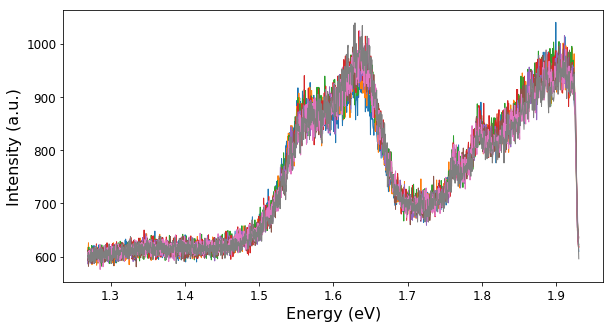

In [21]:
plotSpectra()

##### plot integrated intensities at each point

In [14]:
def plotInt():
    '''generates heat map of integrated spectral intensities at each pixel for forward and reverse scans'''
    global forImage
    global revImage
    global forNorm
    global revNorm
    global scanSize
    %matplotlib inline
    forImage = np.empty([scanRangeY, scanRangeX])
    revImage = np.empty([scanRangeY, scanRangeX])
    from PIL import Image
    dataIm = dataShaped.sum(axis=0)
    for i in range(0,scanRangeX*2,2):
        for j in range(0,scanRangeY*2,2):
            colTemp = int(i/2)
            rowTemp = int(j/2)
            forImage[rowTemp][-colTemp]=dataIm[i+1,j]
            revImage[rowTemp][colTemp]=dataIm[i+1,j+1]
    #normalize forward and reverse images to an intensity of 1
    forNorm = forImage/np.amax(forImage)
    revNorm = revImage/np.amax(forImage)
    # Make forward scan image
    fig, ax = plt.subplots()
    cax = ax.imshow(forImage, interpolation='nearest', cmap=cm.afmhot)
    ax.set_title('Forward Scan')
    # Add colorbar, specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax)
    #make reverse scan image
    fig, ax = plt.subplots()
    cax = ax.imshow(revImage, interpolation='nearest', cmap=cm.afmhot)
    ax.set_title('Reverse Scan')
    # Add colorbar, specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax) #, ticks=[0, np.amax(forImage)]
    #cbar.ax.set_yticklabels(['0', '> 1'])  # vertically oriented colorbar
    forIntTotStr = fileName + '_totalIntFor.png'
    plt.savefig(forIntTotStr)
    forIntTotalStr = fileName + '_totalIntFor'
    testInt = forNorm[:,:].reshape(-1,1)
    write5 = []
    for i in range(0,len(testInt)):
        write5.append(testInt[i][0])
    write_gsf(forIntTotalStr, write5, scanRangeX, scanRangeY,
              xreal=None, yreal=None, xyunits=None, zunits=None, title=None)
    revIntTotStr = fileName + '_totalIntrev.png'
    plt.savefig(revIntTotStr)
    revIntTotalStr = fileName + '_totalIntrev'
    testInt = revNorm[:,:].reshape(-1,1)
    write5 = []
    for i in range(0,len(testInt)):
        write5.append(testInt[i][0])
    write_gsf(revIntTotalStr, write5, scanRangeX, scanRangeY,
              xreal=None, yreal=None, xyunits=None, zunits=None, title=None)
    plt.show()

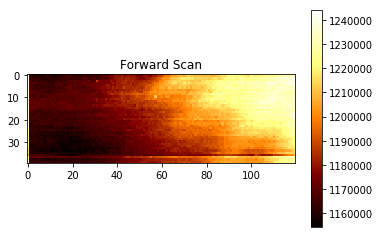

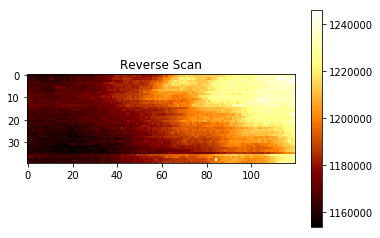

In [15]:
plotInt()

##### plot example spectrum to determine fit range

In [22]:
def setRange(specNum,rangeLow,rangeHigh):
    '''Set range to fit, in pixel number from "rangeLow" to "rangeHigh". First input sets which spectrum will be plotted (see line 11 to change second index)'''
    global x_data
    global y_data
    global rangeH
    global rangeL
    %matplotlib inline
    rangeH = rangeHigh
    rangeL = rangeLow
    x_data = wavelength[rangeLow:rangeHigh]
    y_data = dataShaped[rangeLow:rangeHigh, 5, specNum]
    # And plot it
    plt.figure(figsize=(6, 4))
    return plt.scatter(x_data, y_data)

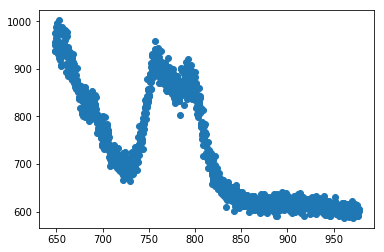

In [23]:
setRange(1, 25, 1600)

##### fit example spectrum from above and set fit params and bounds, define several fitting functions that can be used

In [17]:
def lor1(x, a, b, c, m, g):
    return (a*(c/2)**2)/((x-b)**2 + (c/2)**2) + m*x + g;

In [18]:
def lor2(x, a, b, c, d, e, f, g):
    return (a*(c/2)**2)/((x-b)**2 + (c/2)**2)+ (d*(f/2)**2)/((x-e)**2 + (f/2)**2) + g;

In [19]:
def lor4(x, a, b, c, d, e, f, h, i, j, k, l, m, g):
    return (a*(c/2)**2)/((x-b)**2 + (c/2)**2) + (d*(f/2)**2)/((x-e)**2 + (f/2)**2) + (h*(j/2)**2)/((x-i)**2 + (j/2)**2) + (k*(m/2)**2)/((x-l)**2 + (m/2)**2)+ g;

In [20]:
def fitSpectrum1():
    '''fits to one lorentzian with params: int, position, width, offset.'''
    global x_data
    global y_data
    global initParams
    global paramBounds
    global params1
    initParams=[10, 890, 40,-0.001, 500]
    paramBounds=([0, 870, 35, -1, 0],[1000, 950, 45, 1, 7000])
    params1, params_covariance = optimize.curve_fit(lor1, x_data, y_data,p0=initParams,sigma=None,absolute_sigma=False,check_finite=True,bounds=paramBounds)
    print(params1)
    plt.figure(figsize=(6, 4))
    plt.scatter(x_data, y_data, label='Data')
    plt.plot(x_data, lor1(x_data, params1[0], params1[1], params1[2], params1[3], params1[4]), color = 'k',
            label='Fitted function')
    plt.legend(loc='best')
    plt.savefig('onSlit.png')
    return plt.show()

In [21]:
def fitSpectrum1V():
    '''fits to one Voigt peak with params: int, position, width, offset.'''
    global x_data
    global y_data
    global initParams
    global paramBounds
    global params1
    initParams=[10000, 755, 10, 10, 800]
    paramBounds=([0, 0, 0,0, 0],[1000000, 780, 40, 40, 5000])
    params1, params_covariance = optimize.curve_fit(V, x_data, y_data,p0=initParams,sigma=None,absolute_sigma=False,check_finite=True,bounds=paramBounds)
    print(params1)
    plt.figure(figsize=(6, 4))
    plt.scatter(x_data, y_data, label='Data')
    plt.plot(x_data, V(x_data, params1[0], params1[1], params1[2], params1[3], params1[4]), color = 'k',
            label='Fitted function')
    plt.legend(loc='best')
    plt.savefig('onSlit.png')
    return plt.show()

In [22]:
def V1(x, amp1, x01, alpha1, gamma1, offset):
    """
    Return the Voigt line shape at x with Lorentzian component HWHM gamma
    and Gaussian component HWHM alpha.

    """
    sigma1 = alpha1 / np.sqrt(2 * np.log(2))
    return offset + amp1 * np.real(wofz(((x-x01) + 1j*gamma1)/sigma1/np.sqrt(2))) / sigma1\
           /np.sqrt(2*np.pi)

def V4(x, amp1, x01, alpha1, gamma1,amp2, x02, alpha2, gamma2, amp3, x03, alpha3, gamma3,amp4, x04, alpha4, gamma4,offset):
    """
    Return the 4 Voigt line shapes at x's with Lorentzian component HWHM gamma
    and Gaussian component HWHM alpha.

    """
    sigma1 = alpha1 / np.sqrt(2 * np.log(2))
    sigma2 = alpha2 / np.sqrt(2 * np.log(2))
    sigma3 = alpha3 / np.sqrt(2 * np.log(2))
    sigma4 = alpha4 / np.sqrt(2 * np.log(2))
    return offset + amp1 * np.real(wofz(((x-x01) + 1j*gamma1)/sigma1/np.sqrt(2))) / sigma1\
           /np.sqrt(2*np.pi) + amp2 * np.real(wofz(((x-x02) + 1j*gamma2)/sigma2/np.sqrt(2))) / sigma2\
           /np.sqrt(2*np.pi)+ amp3 * np.real(wofz(((x-x03) + 1j*gamma3)/sigma3/np.sqrt(2))) / sigma3\
           /np.sqrt(2*np.pi) + amp4 * np.real(wofz(((x-x04) + 1j*gamma4)/sigma4/np.sqrt(2))) / sigma4\
           /np.sqrt(2*np.pi)
def fitSpectrum4V():
    '''fits to 4 voigt peaks'''
    global x_data
    global y_data
    global initParams
    global paramBounds
    global params
    
    initParams=[10000, 655, 10, 10, 10000, 755, 10, 10, 10000, 795, 10, 10, 10000, 895, 0.1, 10, 595]
    paramBounds=([0, 600, 0,0, 0, 700, 0, 0,0, 750, 0,0, 0, 860, 0, 0, 590],[1000000, 700, 60, 60, 1000000, 780, 40, 40,1000000, 810, 40, 40, 1000000, 990, 100, 100,600])
    params, params_covariance = optimize.curve_fit(V4, x_data, y_data,p0=initParams,sigma=None,absolute_sigma=False,check_finite=True,bounds=paramBounds)
    print(params)
    plt.figure(figsize=(6, 4))
    plt.scatter(x_data, y_data, label='Data')
    plt.plot(x_data, V4(x_data, params[0], params[1], params[2], params[3], params[4], params[5], params[6], params[7], params[8], params[9], params[10], params[11], params[12], params[13], params[14], params[15], params[16]), color = 'k',
            label='Fitted function')
    plt.plot(x_data, V1(x_data, params[0], params[1], params[2], params[3], params[16]),color = 'r',label='Fitted function1')
    plt.plot(x_data, V1(x_data, params[4], params[5], params[6], params[7], params[16]),color = 'g',label='Fitted function2')
    plt.plot(x_data, V1(x_data, params[8], params[9], params[10], params[11], params[16]),color = 'y',label='Fitted function3')
    plt.plot(x_data, V1(x_data, params[12], params[13], params[14], params[15], params[16]),color = 'c',label='Fitted function4')
    plt.xlabel('Wavelength (nm)', fontsize = 16)
    plt.ylabel('Intensity (a.u.)',fontsize = 16)
    plt.savefig('onSlit.png')
    return plt.show()

[6.06722050e+04 6.25134268e+02 6.00000000e+01 9.97710692e+00
 7.74582678e+03 7.58570950e+02 1.48042196e+01 2.72335641e-11
 1.37593989e+04 7.93235288e+02 1.25765551e+01 1.08064449e+01
 2.86881547e+03 9.00847691e+02 6.62653483e+01 1.25222046e-08
 5.90000000e+02]


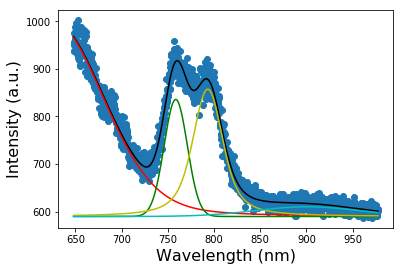

In [23]:
fitSpectrum4V()

In [24]:
def lor1(x, a, b, c, g):
    return (a*(c/2)**2)/((x-b)**2 + (c/2)**2) + g;
def fitSpectrum4():
    '''fits to four lorentzians with params: int, position, width, offset.'''
    global x_data
    global y_data
    global initParams
    global paramBounds
    initParams=[600,664.5, 82.3, 1000,751, 20, 1000, 788, 30, 30, 893, 34.7, 590]
    paramBounds=([0, 620, 42, 0, 750, 19.0, 0, 785, 30, 0, 850, 30,0],[10000, 670, 110,10000, 752, 25, 10000, 791, 47, 150, 895, 100, 6000])
    params, params_covariance = optimize.curve_fit(lor4, x_data, y_data,p0=initParams,sigma=None,absolute_sigma=False,check_finite=True,bounds=paramBounds)
    print(params)
    plt.figure(figsize=(6, 4))
    plt.scatter(x_data, y_data, label='Data')
    plt.plot(x_data, lor4(x_data, params[0], params[1], params[2], params[3], params[4], params[5], params[6], params[7], params[8], params[9], params[10], params[11], params[12]),
            color = 'k', label='Fitted function')
    plt.plot(x_data, lor1(x_data, params[0], params[1], params[2], params[12]),color = 'r',label='Fitted function1')
    plt.plot(x_data, lor1(x_data, params[3], params[4], params[5], params[12]),color = 'g',label='Fitted function2')
    plt.plot(x_data, lor1(x_data, params[6], params[7], params[8], params[12]),color = 'y',label='Fitted function3')
    plt.plot(x_data, lor1(x_data, params[9], params[10], params[11], params[12]),color = 'c',label='Fitted function4')
    #plt.legend(loc='best')
    plt.savefig('onSlit.png')
    return plt.show()

In [25]:
def lor1(x, a, b, c, g):
    return (a*(c/2)**2)/((x-b)**2 + (c/2)**2) + g;
def lor2(x, a, b, c, d, e, f, g):
    return (a*(c/2)**2)/((x-b)**2 + (c/2)**2)+ (d*(f/2)**2)/((x-e)**2 + (f/2)**2) + g;
def fitSpectrum2():
    '''fits to 2 lorentzians with params: int, position, width, offset.'''
    global x_data
    global y_data
    global initParams
    global paramBounds
    initParams=[10000,750, 30, 10000, 788, 30, 590]
    paramBounds=([0, 740, 10, 0, 780, 19.8, 0],[10000000, 765, 80, 10000000, 820, 80, 6000])
    params, params_covariance = optimize.curve_fit(lor2, x_data, y_data,p0=initParams,sigma=None,absolute_sigma=False,check_finite=True,bounds=paramBounds)
    print(params)
    plt.figure(figsize=(6, 4))
    plt.scatter(x_data, y_data, label='Data')
    plt.plot(x_data, lor2(x_data, params[0], params[1], params[2], params[3], params[4], params[5], params[6]),
            label='Fitted function')
    plt.plot(x_data, lor1(x_data, params[0], params[1], params[2], params[6]),color = 'r',label='Fitted function1')
    plt.plot(x_data, lor1(x_data, params[3], params[4], params[5], params[6]),label='Fitted function2')
    #plt.legend(loc='best')
    plt.savefig('onSlit.png')
    return plt.show()

In [29]:
def V2(x, amp1, x01, alpha1, gamma1,amp2, x02, alpha2, gamma2, offset):
    """
    Return the Voigt line shape at x with Lorentzian component HWHM gamma
    and Gaussian component HWHM alpha.

    """
    sigma1 = alpha1 / np.sqrt(2 * np.log(2))
    sigma2 = alpha2 / np.sqrt(2 * np.log(2))
    return offset + amp1 * np.real(wofz(((x-x01) + 1j*gamma1)/sigma1/np.sqrt(2))) / sigma1\
           /np.sqrt(2*np.pi) + amp2 * np.real(wofz(((x-x02) + 1j*gamma2)/sigma2/np.sqrt(2))) / sigma2\
                                                           /np.sqrt(2*np.pi)
def fitSpectrum2V():
    '''fits to one lorentzian with params: int, position, width, offset.'''
    global x_data
    global y_data
    global initParams
    global paramBounds
    global params1
    initParams=[10000,658, 0.05,10, 10000, 665, 0.05, 20, 590]
    paramBounds=([0, 623, 0, 0, 8, 660, 0, 5, 0],[10000000, 660, 1,12, 10000000, 688, 100,100, 6000])
    params1, params_covariance = optimize.curve_fit(V2, x_data, y_data,p0=initParams,sigma=None,absolute_sigma=False,check_finite=True,bounds=paramBounds)
    print(params1)
    plt.figure(figsize=(6, 4))
    plt.scatter(x_data, y_data, label='Data')
    plt.plot(x_data, V2(x_data, params1[0], params1[1], params1[2], params1[3], params1[4], params1[5], params1[6], params1[7], params1[8]), color = 'k',
            label='Fitted function')
    plt.plot(x_data, V1(x_data, params1[0], params1[1], params1[2], params1[3], params1[8]),color = 'r',label='Fitted function1')
    plt.plot(x_data, V1(x_data, params1[4], params1[5], params1[6], params1[7], params1[8]),color = 'g',label='Fitted function2')
    plt.legend(loc='best')
    plt.savefig('onSlit.png')
    return plt.show()

##### Fit and plot subset of spectra defined by indexStep variable, output fit params to array testParams. Choose script to match fitting function from above

In [26]:
def fitSubset2Lor(indexStep,fitFunction):
    global testParams
    global funcName
    global rangeL
    global rangeH
    global initParams
    global paramBounds
    global params1
    funcName = fitFunction
    testParams = []
    #loop that fits and plots test spectra
    for i in range(0,scanRangeX*2, indexStep*2):
        for j in range(0,scanRangeY*2,indexStep*2):
            #print spectrum number
            print(str(i)+','+str(j))
            #cycle through spectra in specified range
            y_data = dataShaped[rangeL:rangeH, i, j+1]
            #fitting to test_func
            params, params_covariance = optimize.curve_fit(funcName, x_data, y_data, p0=initParams, sigma=None,absolute_sigma=False, check_finite=True, bounds=paramBounds)
            params1 = params
            #plot data and fit
            plt.figure(figsize=(6, 4))
            plt.scatter(x_data, y_data, label='Data')
            plt.plot(x_data, funcName(x_data, params[0], params[1], params[2], params[3], params[4], params[5], params[6]), color = 'k')
            plt.plot(x_data, lor1(x_data, params[0], params[1], params[2], params[6]),color = 'r',label='Fitted function1')
            plt.plot(x_data, lor1(x_data, params[3], params[4], params[5], params[6]),label='Fitted function2')
            #plt.legend(loc='best')
            testParams.append(params)
            plt.show()
            print(params)

In [27]:
def fitSubset4Lor(indexStep,fitFunction):
    global testParams
    global funcName
    global rangeL
    global rangeH
    global initParams
    global paramBounds
    global params1
    funcName = fitFunction
    testParams = []
    #loop that fits and plots test spectra
    for i in range(0,scanRangeX*2, indexStep*2):
        for j in range(0,scanRangeY*2,indexStep*2):
            #print spectrum number
            print(str(i)+','+str(j))
            #cycle through spectra in specified range
            y_data = dataShaped[rangeL:rangeH, i, j+1]
            #fitting to test_func
            params, params_covariance = optimize.curve_fit(funcName, x_data, y_data, p0=initParams, sigma=None,absolute_sigma=False, check_finite=True, bounds=paramBounds)
            params1 = params
            #plot data and fit
            plt.figure(figsize=(6, 4))
            plt.scatter(x_data, y_data,s=4, label='Data')
            plt.plot(x_data, funcName(x_data, params[0], params[1], params[2], params[3], params[4], params[5], params[6], params[7], params[8], params[9], params[10], params[11], params[12]),
            color = 'k', label='Fitted function')
            plt.plot(x_data, lor1(x_data, params[0], params[1], params[2], params[12]),color = 'r',label='Fitted function1')
            plt.plot(x_data, lor1(x_data, params[3], params[4], params[5], params[12]),color = 'g',label='Fitted function2')
            plt.plot(x_data, lor1(x_data, params[6], params[7], params[8], params[12]),color = 'y',label='Fitted function3')
            plt.plot(x_data, lor1(x_data, params[9], params[10], params[11], params[12]),color = 'c',label='Fitted function4')
            #plt.legend(loc='best')
            testParams.append(params)
            plt.show()
            print(params)

In [28]:
def fitSubset4V(indexStep,fitFunction):
    global testParams
    global funcName
    global rangeL
    global rangeH
    global initParams
    global paramBounds
    global params1
    funcName = fitFunction
    testParams = []
    #loop that fits and plots test spectra
    for i in range(1,scanRangeX*2, indexStep*2):
        for j in range(1,scanRangeY*2,indexStep*2):
            #print spectrum number
            print(str(i)+','+str(j))
            #cycle through spectra in specified range
            y_data = dataShaped[rangeL:rangeH, i, j+1]
            #fitting to test_func
            params, params_covariance = optimize.curve_fit(funcName, x_data, y_data, p0=initParams, sigma=None,absolute_sigma=False, check_finite=True, bounds=paramBounds)
            params1 = params
            #plot data and fit
            plt.figure(figsize=(6, 4))
            plt.scatter(x_data, y_data, label='Data')
            plt.plot(x_data, V4(x_data, params[0], params[1], params[2], params[3], params[4], params[5], params[6], params[7], params[8], params[9], params[10], params[11], params[12], params[13], params[14], params[15], params[16]), color = 'k',
                label='Fitted function')
            plt.plot(x_data, V1(x_data, params[0], params[1], params[2], params[3], params[16]),color = 'r',label='Fitted function1')
            plt.plot(x_data, V1(x_data, params[4], params[5], params[6], params[7], params[16]),color = 'g',label='Fitted function2')
            plt.plot(x_data, V1(x_data, params[8], params[9], params[10], params[11], params[16]),color = 'y',label='Fitted function3')
            plt.plot(x_data, V1(x_data, params[12], params[13], params[14], params[15], params[16]),color = 'c',label='Fitted function4')
            testParams.append(params)
            plt.show()
            print(params)

In [30]:
def fitSubset2V(indexStep,fitFunction):
    global testParams
    global funcName
    global rangeL
    global rangeH
    global initParams
    global paramBounds
    global params1
    funcName = fitFunction
    testParams = []
    #loop that fits and plots test spectra
    for i in range(1,scanRangeX*2, indexStep*2):
        for j in range(0,scanRangeY*2,indexStep*2):
            #print spectrum number
            print(str(i)+','+str(j))
            #cycle through spectra in specified range
            y_data = dataShaped[rangeL:rangeH, i, j+1]
            #fitting to test_func
            params, params_covariance = optimize.curve_fit(funcName, x_data, y_data, p0=initParams, sigma=None,absolute_sigma=False, check_finite=True, bounds=paramBounds)
            params1 = params
            #plot data and fit
            plt.figure(figsize=(6, 4))
            plt.scatter(x_data, y_data, label='Data')
            plt.plot(x_data, V2(x_data, params[0], params[1], params[2], params[3], params[4], params[5], params[6], params[7], params[8]), color = 'k',
                label='Fitted function')
            plt.plot(x_data, V1(x_data, params[0], params[1], params[2], params[3], params[8]),color = 'r',label='Fitted function1')
            plt.plot(x_data, V1(x_data, params[4], params[5], params[6], params[7], params[8]),color = 'g',label='Fitted function2')
            testParams.append(params)
            plt.show()
            print(params)

1,1


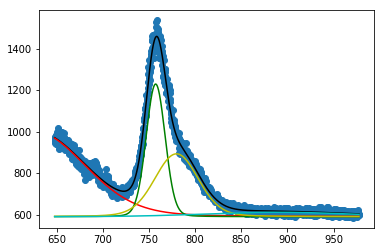

[5.96564215e+04 6.25795775e+02 6.00000000e+01 8.47399305e+00
 1.70230474e+04 7.57243308e+02 1.15922536e+01 9.56812683e-01
 1.89760228e+04 7.79830557e+02 2.53685149e+01 4.18101018e+00
 4.15892914e+03 8.89120503e+02 9.22659919e+01 9.74305044e-04
 5.90000000e+02]
1,31


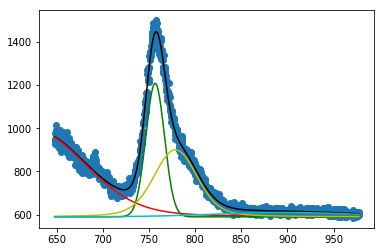

[5.93492266e+04 6.26088598e+02 6.00000000e+01 1.03106003e+01
 1.55968530e+04 7.56718921e+02 1.18559957e+01 7.69609959e-10
 2.01552046e+04 7.78741406e+02 2.35990958e+01 6.99575952e+00
 3.82476265e+03 8.97574145e+02 8.96175810e+01 1.07615250e-04
 5.90000000e+02]
1,61


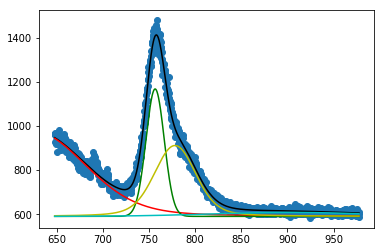

[5.88530838e+04 6.24796545e+02 6.00000000e+01 1.18838601e+01
 1.42938971e+04 7.56682466e+02 1.16007440e+01 4.29468186e-20
 2.01675460e+04 7.78212171e+02 2.24326970e+01 7.02371349e+00
 3.84967386e+03 9.01349591e+02 1.00000000e+02 2.98041744e-06
 5.90000000e+02]
31,1


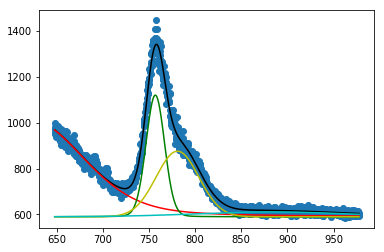

[7.02421278e+04 6.19611568e+02 6.00000000e+01 1.78367351e+01
 1.36291708e+04 7.56879091e+02 1.14713517e+01 6.44947573e-01
 1.65613572e+04 7.80886519e+02 2.72391106e+01 1.25861625e-04
 4.30416984e+03 8.82634775e+02 9.66372068e+01 6.17770588e-03
 5.90000000e+02]
31,31


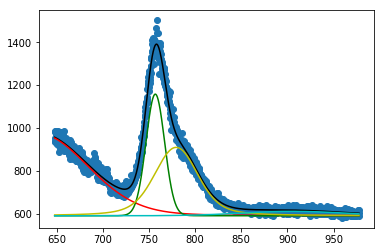

[5.37657392e+04 6.30112630e+02 6.00000000e+01 6.12509067e+00
 1.44408799e+04 7.56873205e+02 1.18243205e+01 1.26909686e-01
 2.15492801e+04 7.79460771e+02 2.23307515e+01 9.25115303e+00
 2.88829670e+03 9.06260373e+02 6.59236163e+01 5.89130074e-05
 5.90000000e+02]
31,61


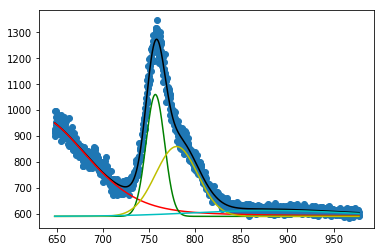

[6.36059807e+04 6.22832262e+02 6.00000000e+01 1.56405191e+01
 1.18158097e+04 7.56920399e+02 1.17977983e+01 1.98534069e-22
 1.53723422e+04 7.79956585e+02 2.67891983e+01 2.66770493e-07
 4.67553803e+03 8.80950553e+02 9.66495631e+01 5.35559786e-11
 5.90000000e+02]
61,1


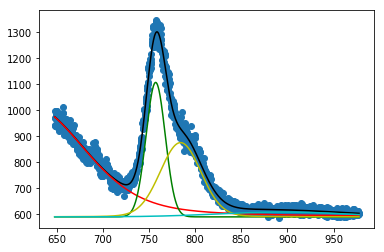

[7.60151279e+04 6.18358545e+02 6.00000000e+01 2.22947795e+01
 1.35051401e+04 7.57267212e+02 1.22560482e+01 1.91297089e-22
 1.63014417e+04 7.84191343e+02 2.48899510e+01 1.98017983e+00
 3.21295076e+03 8.93421384e+02 8.21181681e+01 1.09273375e-07
 5.90000000e+02]
61,31


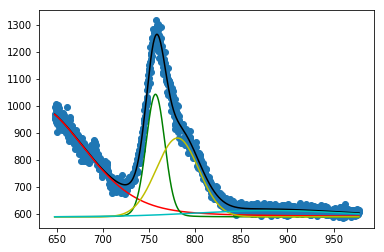

[6.63764160e+04 6.22049268e+02 6.00000000e+01 1.45893779e+01
 1.18272986e+04 7.57077366e+02 1.15061078e+01 8.07535992e-01
 1.67278380e+04 7.80872642e+02 2.70096370e+01 7.90448998e-27
 4.67229638e+03 8.81687930e+02 9.40979081e+01 4.59639001e-04
 5.90000000e+02]
61,61


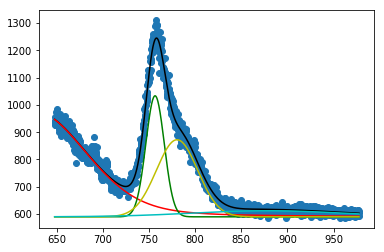

[6.15433738e+04 6.24202825e+02 6.00000000e+01 1.46098521e+01
 1.10610329e+04 7.56617991e+02 1.17192499e+01 2.47704561e-03
 1.57531522e+04 7.80387754e+02 2.62089460e+01 2.94568623e-17
 4.56909176e+03 8.78356496e+02 9.63126486e+01 3.31953218e-06
 5.90000000e+02]
91,1


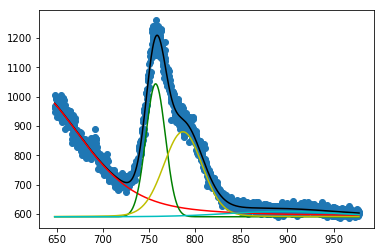

[8.22064927e+04 6.12448878e+02 6.00000000e+01 2.43834147e+01
 1.20668583e+04 7.57223144e+02 1.24885823e+01 1.60770081e-21
 1.58433221e+04 7.86812263e+02 2.33267541e+01 2.42944771e+00
 2.72089261e+03 8.95802555e+02 7.04605620e+01 7.21342438e-09
 5.90000000e+02]
91,31


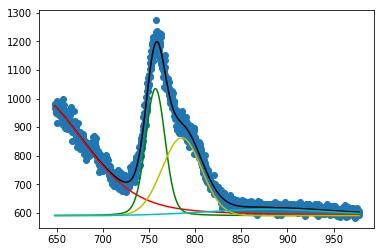

[7.05859241e+04 6.20016965e+02 6.00000000e+01 1.72543186e+01
 1.24795205e+04 7.57007850e+02 1.13378196e+01 1.90179560e+00
 1.45416726e+04 7.85515492e+02 2.50561633e+01 1.01572289e-13
 3.77277721e+03 8.79948465e+02 8.03236306e+01 2.16311383e-08
 5.90000000e+02]
91,61


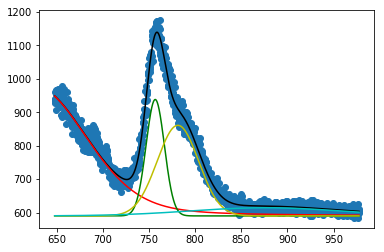

[6.11049180e+04 6.24615127e+02 6.00000000e+01 1.38985060e+01
 8.66074524e+03 7.56796631e+02 1.16893989e+01 1.21735822e-09
 1.51943171e+04 7.81325805e+02 2.63512657e+01 2.05122106e-09
 4.98948410e+03 8.76242703e+02 9.59378374e+01 6.75963623e-15
 5.90000000e+02]
121,1


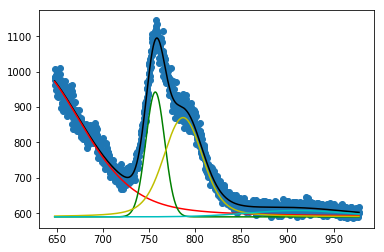

[7.30085846e+04 6.16533985e+02 6.00000000e+01 1.80718490e+01
 9.08050964e+03 7.56848877e+02 1.21049784e+01 5.70635249e-12
 1.68682517e+04 7.86991192e+02 2.06337428e+01 7.61181727e+00
 2.37198265e+03 9.10348672e+02 6.22538259e+01 7.84979318e-05
 5.90000000e+02]
121,31


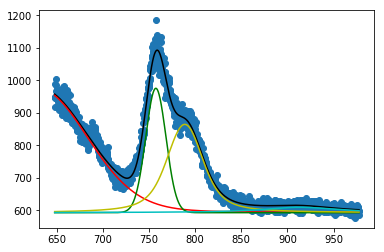

[5.35269125e+04 6.29863409e+02 6.00000000e+01 6.08299167e+00
 1.05552038e+04 7.57462193e+02 1.29610230e+01 4.05247194e-35
 1.65956164e+04 7.88806444e+02 1.55759743e+01 1.23143899e+01
 2.56262508e+03 9.13569510e+02 5.13685879e-05 4.90071739e+01
 5.93134930e+02]
121,61


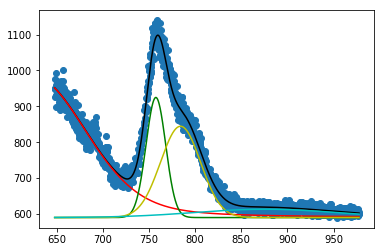

[6.35851788e+04 6.23783817e+02 6.00000000e+01 1.59612489e+01
 8.95052073e+03 7.57489576e+02 1.25584330e+01 3.84328302e-09
 1.38342968e+04 7.84180768e+02 2.55305042e+01 2.16225035e-10
 4.45985606e+03 8.75983764e+02 9.00767919e+01 2.51675429e-07
 5.90000000e+02]
151,1


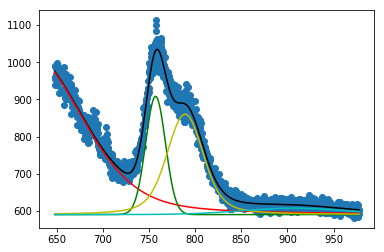

[7.33501599e+04 6.16941270e+02 6.00000000e+01 1.83652668e+01
 8.55216848e+03 7.57168515e+02 1.26305075e+01 5.85493821e-13
 1.55230069e+04 7.89137127e+02 1.83023428e+01 8.52894954e+00
 2.44321206e+03 9.06693009e+02 6.61842195e+01 3.21093094e-06
 5.90000000e+02]
151,31


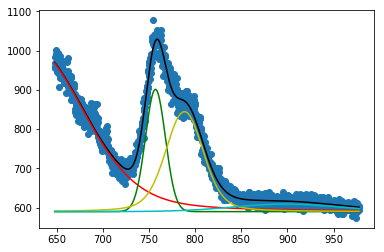

[6.77588266e+04 6.21114244e+02 6.00000000e+01 1.57308675e+01
 8.43421555e+03 7.57001876e+02 1.27311989e+01 6.43309978e-16
 1.45092710e+04 7.88379336e+02 2.04037937e+01 6.41538648e+00
 2.80398642e+03 8.98968372e+02 6.84326426e+01 1.40480035e-10
 5.90000000e+02]
151,61


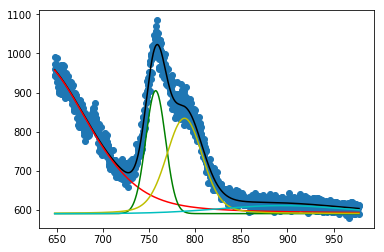

[6.53863578e+04 6.22383506e+02 6.00000000e+01 1.60749698e+01
 8.46159276e+03 7.57241592e+02 1.26298300e+01 1.25769763e-13
 1.30127927e+04 7.88463537e+02 2.02606443e+01 4.87291460e+00
 3.47590494e+03 8.94159272e+02 7.96479087e+01 1.02145392e-07
 5.90000000e+02]
181,1


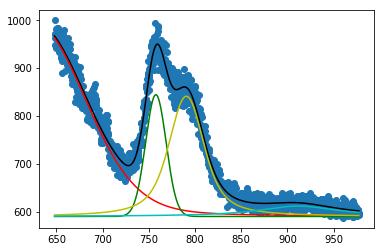

[5.88657279e+04 6.26618756e+02 6.00000000e+01 8.98200886e+00
 7.11943825e+03 7.57613310e+02 1.31452909e+01 1.54744678e-37
 1.53672866e+04 7.90629117e+02 1.39657691e+01 1.35760294e+01
 3.52787900e+03 9.11644399e+02 2.01924122e-03 5.14507226e+01
 5.90000000e+02]
181,31


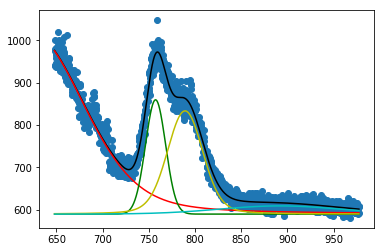

[6.95678382e+04 6.20689871e+02 5.99999999e+01 1.62003892e+01
 7.36998097e+03 7.57289026e+02 1.28501440e+01 1.51300904e-09
 1.27059469e+04 7.89230154e+02 2.01968665e+01 4.42670574e+00
 3.16426897e+03 8.91929652e+02 7.69244006e+01 1.87765599e-06
 5.90000000e+02]
181,61


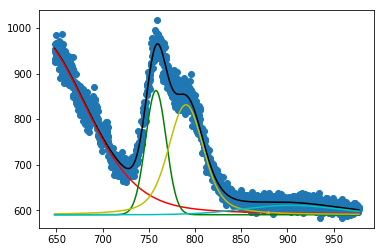

[6.16557167e+04 6.23680136e+02 6.00000000e+01 1.29453404e+01
 7.62706705e+03 7.57666525e+02 1.31340949e+01 3.05796086e-27
 1.35158346e+04 7.90191429e+02 1.73953797e+01 8.69222169e+00
 2.65212875e+03 9.03813611e+02 6.05468145e+01 2.80558074e-07
 5.90000000e+02]
211,1


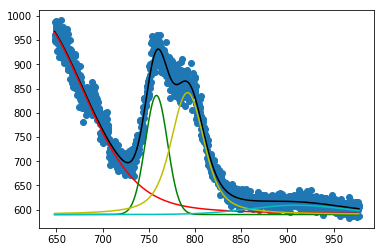

[6.48771354e+04 6.22469032e+02 6.00000000e+01 1.36567660e+01
 7.39465152e+03 7.58232362e+02 1.41310025e+01 1.77949598e-15
 1.39072653e+04 7.91942640e+02 1.46601900e+01 1.06891567e+01
 2.47585006e+03 9.09634076e+02 6.05984398e+01 1.77694531e-07
 5.90000000e+02]
211,31


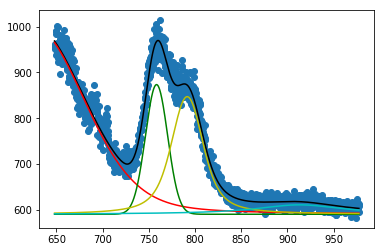

[6.37735059e+04 6.23202196e+02 6.00000000e+01 1.27651018e+01
 8.53789420e+03 7.58364032e+02 1.41547247e+01 1.62103967e-28
 1.39928784e+04 7.91539776e+02 1.32597256e+01 1.14577329e+01
 3.71281803e+03 9.13056893e+02 5.86860604e-05 5.74433420e+01
 5.90000000e+02]
211,61


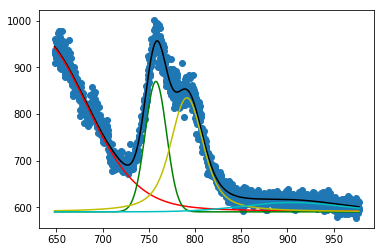

[5.54065620e+04 6.27536663e+02 6.00000000e+01 9.24697015e+00
 8.10881195e+03 7.57614541e+02 1.36179255e+01 1.18993427e-09
 1.34873325e+04 7.91228646e+02 1.38964931e+01 1.12478836e+01
 2.69198177e+03 9.04960955e+02 6.31691926e+01 6.04806448e-13
 5.90000000e+02]


In [35]:
fitSubset4V(15,V4)

##### fit all spectra, output fit params to array allParams. Fitting errors result in parameters of '0' value and the relevant spectrum number is printed.

In [33]:
def fitSpectraFor(rangeLow,rangeHigh):
    '''fit all forward spectra to test_func and store fit params in rows of allParamsFor array-- new'''
    global forParams
    global wavelength
    global params1
    global funcName
    global integrationParams
    integrationParams = np.empty([scanRangeY, scanRangeX,2])
    forParams = np.empty([scanRangeY, scanRangeX, len(params1)])
    x_data = wavelength[rangeLow:rangeHigh]
    for i in range(0,scanRangeX*2,2):
        print(i)
        for j in range(0,scanRangeY*2,2):
            colTemp = int(i/2)
            rowTemp = int(j/2)
            try:
                y_data = dataShaped[rangeLow:rangeHigh, i+1, j]
                params, params_covariance = optimize.curve_fit(funcName, x_data, y_data,p0=initParams,sigma=None,absolute_sigma=False,check_finite=True,bounds=paramBounds)
                forParams[rowTemp,colTemp,:]=params
                if params[14]>80:
                   forParams[rowTemp,colTemp,:]=[params[0],params[1], params[2], params[3],params[4], params[5], params[6], params[7], params[8], params[9], params[10], params[11], 1, 990, 1, 1, params[16]]
                   print('%d,%d did not fit interlayer'%(i,j))
                elif params[15]>80:
                   forParams[rowTemp,colTemp,:]=[params[0],params[1], params[2], params[3],params[4], params[5], params[6], params[7], params[8], params[9], params[10], params[11], 1, 990, 1, 1, params[16]]
                   print('%d,%d did not fit interlayer'%(i,j))
                else:
                   forParams[rowTemp,colTemp,:]=params
            except RuntimeError:
                forParams[rowTemp,colTemp,:]=[1, 700, 1, 1, 1, 780, 1, 1, 1, 810, 1, 1, 1, 990, 1, 1, 590]
                print('%d,%d did not fit spectrum'%(i,j))
    return print('finished fitting!')

In [36]:
fitSpectraFor(rangeL, rangeH)

0
0,0 did not fit interlayer
0,2 did not fit interlayer
0,4 did not fit interlayer
0,6 did not fit interlayer
0,8 did not fit interlayer
0,10 did not fit interlayer
0,12 did not fit interlayer
0,16 did not fit interlayer
0,18 did not fit interlayer
0,20 did not fit interlayer
0,22 did not fit interlayer
0,24 did not fit interlayer
0,26 did not fit interlayer
0,30 did not fit interlayer
0,32 did not fit interlayer
0,36 did not fit interlayer
0,38 did not fit interlayer
0,40 did not fit interlayer
0,42 did not fit interlayer
0,44 did not fit interlayer
0,46 did not fit interlayer
0,50 did not fit interlayer
0,52 did not fit interlayer
0,54 did not fit interlayer
0,56 did not fit interlayer
0,58 did not fit interlayer
0,60 did not fit interlayer
0,62 did not fit interlayer
0,64 did not fit interlayer
0,66 did not fit interlayer
0,68 did not fit interlayer
0,70 did not fit interlayer
0,78 did not fit interlayer
2
2,2 did not fit interlayer
2,6 did not fit interlayer
2,8 did not fit interla

18,2 did not fit interlayer
18,4 did not fit interlayer
18,10 did not fit interlayer
18,12 did not fit interlayer
18,14 did not fit interlayer
18,16 did not fit interlayer
18,18 did not fit interlayer
18,20 did not fit interlayer
18,24 did not fit interlayer
18,26 did not fit interlayer
18,28 did not fit interlayer
18,32 did not fit interlayer
18,34 did not fit interlayer
18,36 did not fit interlayer
18,38 did not fit interlayer
18,42 did not fit interlayer
18,44 did not fit interlayer
18,46 did not fit interlayer
18,48 did not fit interlayer
18,50 did not fit interlayer
18,52 did not fit interlayer
18,54 did not fit interlayer
18,56 did not fit interlayer
18,58 did not fit interlayer
18,60 did not fit interlayer
18,62 did not fit interlayer
18,66 did not fit interlayer
18,70 did not fit interlayer
18,72 did not fit interlayer
18,76 did not fit interlayer
18,78 did not fit interlayer
20
20,0 did not fit interlayer
20,2 did not fit interlayer
20,4 did not fit interlayer
20,8 did not fit

34,8 did not fit interlayer
34,10 did not fit interlayer
34,12 did not fit interlayer
34,14 did not fit interlayer
34,16 did not fit interlayer
34,20 did not fit interlayer
34,24 did not fit interlayer
34,26 did not fit interlayer
34,30 did not fit interlayer
34,32 did not fit interlayer
34,34 did not fit interlayer
34,36 did not fit interlayer
34,38 did not fit interlayer
34,42 did not fit interlayer
34,44 did not fit interlayer
34,46 did not fit interlayer
34,48 did not fit interlayer
34,50 did not fit interlayer
34,52 did not fit interlayer
34,54 did not fit interlayer
34,56 did not fit interlayer
34,58 did not fit interlayer
34,60 did not fit interlayer
34,62 did not fit interlayer
34,64 did not fit interlayer
34,66 did not fit interlayer
34,68 did not fit interlayer
34,70 did not fit interlayer
34,72 did not fit interlayer
34,74 did not fit interlayer
34,76 did not fit interlayer
34,78 did not fit interlayer
36
36,0 did not fit interlayer
36,4 did not fit interlayer
36,6 did not f

48,70 did not fit interlayer
48,72 did not fit interlayer
48,76 did not fit interlayer
48,78 did not fit interlayer
50
50,2 did not fit interlayer
50,4 did not fit interlayer
50,6 did not fit interlayer
50,8 did not fit interlayer
50,10 did not fit interlayer
50,12 did not fit interlayer
50,14 did not fit interlayer
50,16 did not fit interlayer
50,18 did not fit interlayer
50,20 did not fit interlayer
50,22 did not fit interlayer
50,24 did not fit interlayer
50,26 did not fit interlayer
50,28 did not fit interlayer
50,30 did not fit interlayer
50,32 did not fit interlayer
50,34 did not fit interlayer
50,36 did not fit interlayer
50,38 did not fit interlayer
50,42 did not fit interlayer
50,44 did not fit interlayer
50,46 did not fit interlayer
50,48 did not fit interlayer
50,50 did not fit interlayer
50,52 did not fit interlayer
50,54 did not fit interlayer
50,56 did not fit interlayer
50,58 did not fit interlayer
50,60 did not fit interlayer
50,62 did not fit interlayer
50,64 did not f

64,50 did not fit interlayer
64,52 did not fit interlayer
64,54 did not fit interlayer
64,56 did not fit interlayer
64,58 did not fit interlayer
64,60 did not fit interlayer
64,62 did not fit interlayer
64,66 did not fit interlayer
64,68 did not fit interlayer
64,72 did not fit interlayer
64,74 did not fit interlayer
64,76 did not fit interlayer
64,78 did not fit interlayer
66
66,0 did not fit interlayer
66,2 did not fit interlayer
66,6 did not fit interlayer
66,8 did not fit interlayer
66,10 did not fit interlayer
66,12 did not fit interlayer
66,14 did not fit interlayer
66,16 did not fit interlayer
66,18 did not fit interlayer
66,20 did not fit interlayer
66,22 did not fit interlayer
66,24 did not fit interlayer
66,26 did not fit interlayer
66,28 did not fit interlayer
66,30 did not fit interlayer
66,32 did not fit interlayer
66,34 did not fit interlayer
66,36 did not fit interlayer
66,38 did not fit interlayer
66,40 did not fit interlayer
66,42 did not fit interlayer
66,44 did not f

82
82,8 did not fit interlayer
82,10 did not fit interlayer
82,12 did not fit interlayer
82,14 did not fit interlayer
82,24 did not fit interlayer
82,30 did not fit interlayer
82,34 did not fit interlayer
82,36 did not fit interlayer
82,38 did not fit interlayer
82,42 did not fit interlayer
82,44 did not fit interlayer
82,46 did not fit interlayer
82,48 did not fit interlayer
82,50 did not fit interlayer
82,52 did not fit interlayer
82,54 did not fit interlayer
82,56 did not fit interlayer
82,58 did not fit interlayer
82,60 did not fit interlayer
82,62 did not fit interlayer
82,64 did not fit interlayer
82,66 did not fit interlayer
82,68 did not fit interlayer
82,70 did not fit interlayer
82,72 did not fit interlayer
82,74 did not fit interlayer
82,76 did not fit interlayer
82,78 did not fit interlayer
84
84,4 did not fit interlayer
84,10 did not fit interlayer
84,12 did not fit interlayer
84,14 did not fit interlayer
84,18 did not fit interlayer
84,20 did not fit interlayer
84,22 did 

102,24 did not fit interlayer
102,26 did not fit interlayer
102,32 did not fit interlayer
102,36 did not fit interlayer
102,38 did not fit interlayer
102,40 did not fit interlayer
102,44 did not fit interlayer
102,48 did not fit interlayer
102,52 did not fit interlayer
102,54 did not fit interlayer
102,56 did not fit interlayer
102,60 did not fit interlayer
102,62 did not fit interlayer
102,64 did not fit interlayer
102,66 did not fit interlayer
102,68 did not fit interlayer
102,70 did not fit interlayer
102,72 did not fit interlayer
102,74 did not fit interlayer
102,76 did not fit interlayer
102,78 did not fit interlayer
104
104,2 did not fit interlayer
104,6 did not fit interlayer
104,8 did not fit interlayer
104,12 did not fit interlayer
104,16 did not fit interlayer
104,22 did not fit interlayer
104,24 did not fit interlayer
104,28 did not fit interlayer
104,32 did not fit interlayer
104,38 did not fit interlayer
104,42 did not fit interlayer
104,44 did not fit interlayer
104,46 di

124,66 did not fit interlayer
124,68 did not fit interlayer
124,70 did not fit interlayer
124,72 did not fit interlayer
124,74 did not fit interlayer
124,76 did not fit interlayer
124,78 did not fit interlayer
126
126,20 did not fit spectrum
126,40 did not fit interlayer
126,44 did not fit interlayer
126,46 did not fit interlayer
126,48 did not fit interlayer
126,50 did not fit interlayer
126,52 did not fit interlayer
126,54 did not fit interlayer
126,56 did not fit interlayer
126,58 did not fit interlayer
126,60 did not fit interlayer
126,62 did not fit interlayer
126,64 did not fit interlayer
126,66 did not fit interlayer
126,68 did not fit interlayer
126,70 did not fit interlayer
126,72 did not fit interlayer
126,74 did not fit interlayer
126,76 did not fit interlayer
126,78 did not fit interlayer
128
128,8 did not fit interlayer
128,12 did not fit interlayer
128,32 did not fit interlayer
128,38 did not fit interlayer
128,40 did not fit interlayer
128,46 did not fit interlayer
128,4

170,78 did not fit interlayer
172
172,52 did not fit interlayer
172,70 did not fit interlayer
172,72 did not fit interlayer
174
174,4 did not fit interlayer
174,16 did not fit interlayer
174,26 did not fit interlayer
174,36 did not fit interlayer
174,40 did not fit interlayer
174,48 did not fit interlayer
174,54 did not fit interlayer
174,66 did not fit interlayer
174,68 did not fit interlayer
174,72 did not fit interlayer
174,78 did not fit interlayer
176
176,62 did not fit interlayer
176,66 did not fit interlayer
176,72 did not fit interlayer
176,74 did not fit interlayer
178
178,14 did not fit interlayer
178,16 did not fit interlayer
178,34 did not fit interlayer
178,54 did not fit interlayer
178,64 did not fit interlayer
178,72 did not fit interlayer
178,76 did not fit interlayer
180
180,10 did not fit interlayer
180,56 did not fit interlayer
180,72 did not fit interlayer
182
182,10 did not fit interlayer
182,36 did not fit interlayer
182,40 did not fit interlayer
182,42 did not fi

In [498]:
def V1raw(x, amp1, x01, alpha1, gamma1):
    sigma1 = alpha1 / np.sqrt(2 * np.log(2))
    return amp1 * np.real(wofz(((x-x01) + 1j*gamma1)/sigma1/np.sqrt(2))) / sigma1\
           /np.sqrt(2*np.pi)
def fitSpectraRev2(rangeLow,rangeHigh):
    '''fit all reverse scan spectra to test_func and store fit params in rows of allParamsFor array-- new'''
    global revParams
    global wavelength
    global params1
    global funcName
    global integrationParamsRev
    integrationParamsRev = np.empty([scanRangeY, scanRangeX,2])
    revParams = np.empty([scanRangeY, scanRangeX, len(params1)])
    x_data = wavelength[rangeLow:rangeHigh]
    for i in range(0,scanRangeX*2,2):
        print(i)
        for j in range(0,scanRangeY*2,2):
            colTemp = int(i/2)
            rowTemp = int(j/2)
            try:
                y_data = dataShaped[rangeLow:rangeHigh, i+1, j+1]
                params, params_covariance = optimize.curve_fit(funcName, x_data, y_data,p0=initParams,sigma=None,absolute_sigma=False,check_finite=True,bounds=paramBounds)
                revParams[rowTemp,colTemp,:]=params
                peak1 = V1raw(x_data, params[0], params[1], params[2], params[3])
                peak2 = V1raw(x_data, params[4], params[5], params[6], params[7])
                integrationParamsRev[rowTemp,colTemp,0] = sum(peak1)
                integrationParamsRev[rowTemp,colTemp,1] = sum(peak2)
                #if params[0]<1000:
                #   forParams[rowTemp,colTemp,:]=[1,670, 0.1,0.1, 1, 750, 0.1, 0.1, 590]
                #   print('%d,%d did not fit'%(i,j))
                #elif params[4]<1000:
                #   forParams[rowTemp,colTemp,:]=[params[0],params[1], params[2], params[3], 1, 750, 0.1, 0.1, params[8]]
                #   print('%d,%d did not fit trion'%(i,j))
                #else:
                #   forParams[rowTemp,colTemp,:]=params
            except RuntimeError:
                revParams[rowTemp,colTemp,:]=[1,670, 0.1,0.1, 1, 750, 0.1, 0.1, 590]
                print('%d,%d did not fit'%(i,j))
    return print('finished fitting!')

In [ ]:
fitSpectraRev2(rangeL, rangeH)

In [25]:
def makeIndex():
    '''create image with indices "i" and "j" in so that individual spectra can be identified'''
    global idxParams
    global funcName
    idxParams = np.empty([scanRangeY, scanRangeX, 2])
    for i in range(0,scanRangeX*2,2):
        for j in range(0,scanRangeY*2,2):
            colTemp = int(i/2)
            rowTemp = int(j/2)
            params = [i+1, j]
            idxParams[rowTemp,colTemp,:]=params
    return print('finished index!')

In [26]:
makeIndex()

finished index!


##### Create images from fit params for the intensity, position, and width of peaks for forward scan. 

In [51]:
def plotFitFor(numPks):
    '''generates heat map of fit parameters at each pixel for forward scan and saves each image as a png.'''
    global forPos
    global forInt
    global forWid
    global forParams
    global signalEv
    global signal
    global intParams1
    global test4
    %matplotlib inline
    from PIL import Image
    # Make forward intensity images
    for i in range(0,numPks):
        #normalize forward and reverse intensities to an intensity of 1
        forIntNorm = forParams[:,:,0+i*4]/np.amax(forParams[:,:,0+i*4])
        fig, ax = plt.subplots()
        cax = ax.imshow(forIntNorm, interpolation='nearest', cmap=cm.afmhot)
        ax.set_title('Intensity' + str(i))
        # Add colorbar, specify tick locations to match desired ticklabels
        cbar = fig.colorbar(cax)
        forIntStr = fileName + '_Int' + str(i) +'.png'
        forIntStr1 = fileName + '_Int' + str(i)
        plt.savefig(forIntStr)
        test1 = forParams[:,:,0+i*4].reshape(-1,1)
        write1 = []
        for i in range(0,len(test1)):
            write1.append(test1[i][0])
        write_gsf(forIntStr1, write1, scanRangeX, scanRangeY,xreal=None, yreal=None, xyunits=None, zunits=None, title=None)
#make forward peak position images
    for i in range(0,numPks):
        fig, ax = plt.subplots()
        #forParams[forParams == 0] = 550
        #Raman1 = ((1/532.1)-(1/forParams[:,:,1]))*10**7
        signalEv = 3*4.1357*10**-7/(forParams[:,:,1+i*4]*10**-9)
        #signalEv[signalEv > 2] = 1.42
        #result = np.maximum(signalEv, 1.2)
        #result1 = np.minimum(signalEv, 2)
        cax = ax.imshow(signalEv, interpolation='nearest', cmap=cm.afmhot)
        ax.set_title('Peak Position' + str(i))
        # Add colorbar, specify tick locations to match desired ticklabels
        cbar = fig.colorbar(cax)
        forPosStr = fileName + '_Pos' + str(i)+'.png'
        plt.savefig(forPosStr)
        forPosStr1 = fileName + '_Pos'+ str(i)
        test2 = signalEv.reshape(-1,1)
        write2 = []
        for i in range(0,len(test2)):
            write2.append(test2[i][0])
        write_gsf(forPosStr1, write2, scanRangeX, scanRangeY,
                  xreal=None, yreal=None, xyunits=None, zunits=None, title=None)
    for i in range(0,len(test1)):
        write1.append(test1[i][0])
        write_gsf(forTrionEnergyStr1, write1, scanRangeX, scanRangeY, xreal=None, yreal=None, xyunits=None, zunits=None, title=None)
        #make forward peak width image
    for i in range(0,numPks):
        fig, ax = plt.subplots()
        cax = ax.imshow(forParams[:,:,3+i*4], interpolation='nearest', cmap=cm.afmhot)
        ax.set_title('Peak Width'+str(i))
        # Add colorbar, specify tick locations to match desired ticklabels
        cbar = fig.colorbar(cax)
        forWidStr = fileName + '_forWid' + str(i) +'.png'
        plt.savefig(forWidStr)
        forWidStr1 = fileName + '_forWid'+ str(i)
        test3 = forParams[:,:,2+i*4].reshape(-1,1)
        write3 = []
        for i in range(0,len(test3)):
            write3.append(test3[i][0])
        write_gsf(forWidStr1, write3, scanRangeX, scanRangeY,
                  xreal=None, yreal=None, xyunits=None, zunits=None, title=None)
    #plot the indexing images to determine which spectrum matches which pixel:  y_data = dataShaped[rangeLow:rangeHigh, i, j]
    forIdx1 = idxParams[:,:,0]/np.amax(idxParams[:,:,0])
    fig, ax = plt.subplots()
    cax = ax.imshow(forIdx1, interpolation='nearest', cmap=cm.afmhot)
    ax.set_title('i index')
    # Add colorbar, specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax)
    forIdxStr = fileName + '_idxI' + str(i) +'.png'
    plt.savefig(forIdxStr)
    forIdx1 = fileName + '_idxI'
    test4 = idxParams[:,:,0].reshape(-1,1)
    write4 = []
    for i in range(0,len(test4)):
        write4.append(test4[i][0])
    write_gsf(forIdx1, write4, scanRangeX, scanRangeY, xreal=None, yreal=None, xyunits=None, zunits=None, title=None)
    forIdx2 = idxParams[:,:,1]/np.amax(idxParams[:,:,1])
    fig, ax = plt.subplots()
    cax = ax.imshow(forIdx2, interpolation='nearest', cmap=cm.afmhot)
    ax.set_title('j index')
    # relevant y_data = dataShaped[rangeLow:rangeHigh, i, j]
    cbar = fig.colorbar(cax)
    forIdxStr = fileName + '_idxJ.png'
    plt.savefig(forIdxStr)
    forIdx2 = fileName + '_idxJ'
    test5 = idxParams[:,:,1].reshape(-1,1)
    write5 = []
    for i in range(0,len(test5)):
        write5.append(test5[i][0])
    write_gsf(forIdx2, write5, scanRangeX, scanRangeY, xreal=None, yreal=None, xyunits=None, zunits=None, title=None)
    plt.show()

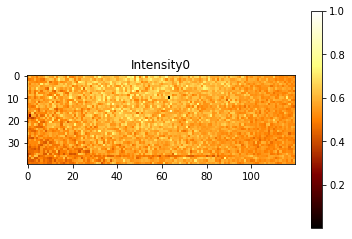

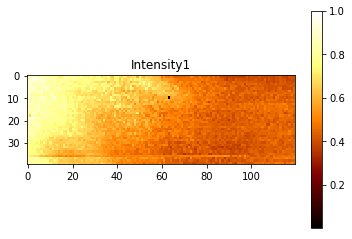

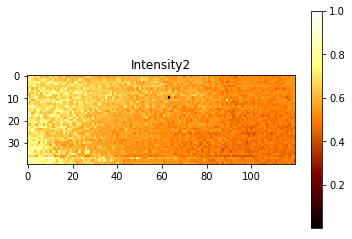

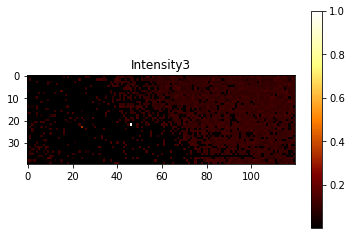

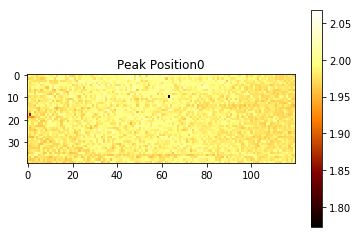

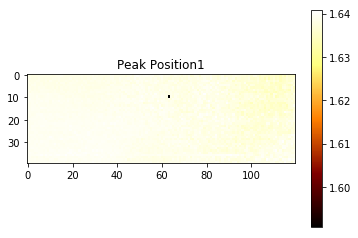

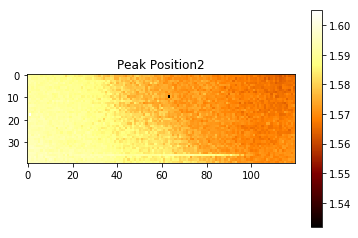

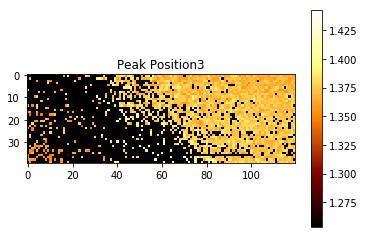

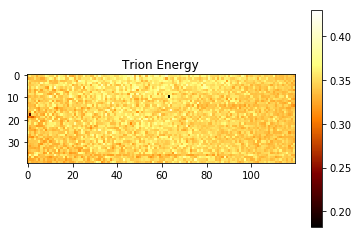

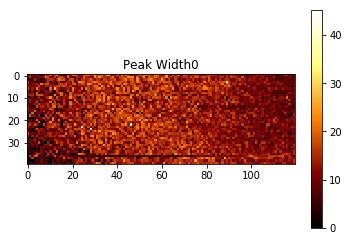

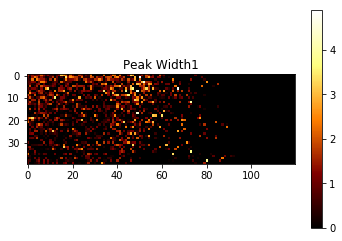

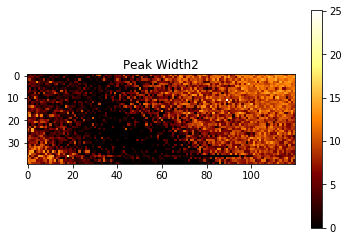

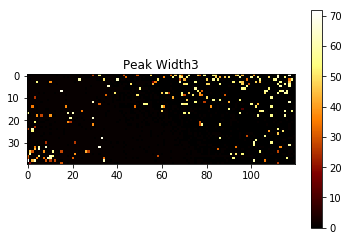

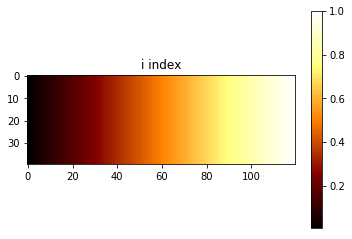

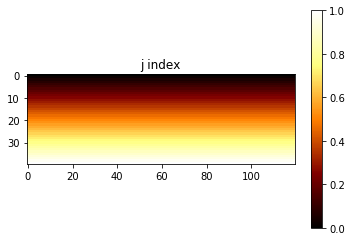

In [52]:
plotFitFor(4)

In [509]:
def plotFitRev(numPks):
    '''generates heat map of fit parameters at each pixel for forward scan and saves each image as a png.'''
    global revParams
    global signalEv
    global signal
    global integrationParamsRev
    %matplotlib inline
    from PIL import Image
    # Make forward intensity images
    for i in range(0,numPks):
        #normalize forward and reverse intensities to an intensity of 1
        revIntNorm = revParams[:,:,0+i*4]/np.amax(revParams[:,:,0+i*4])
        fig, ax = plt.subplots()
        cax = ax.imshow(revIntNorm, interpolation='nearest', cmap=cm.afmhot)
        ax.set_title('Intensity' + str(i))
        # Add colorbar, specify tick locations to match desired ticklabels
        cbar = fig.colorbar(cax)
        revIntStr = fileName + '_revInt' + str(i) +'.png'
        revIntStr1 = fileName + '_revInt' + str(i)
        plt.savefig(revIntStr)
        test1 = revParams[:,:,0+i*4].reshape(-1,1)
        write1 = []
        for i in range(0,len(test1)):
            write1.append(test1[i][0])
        write_gsf(revIntStr1, write1, scanRangeX, scanRangeY,
                  xreal=None, yreal=None, xyunits=None, zunits=None, title=None)
    #Take ratio of Exciton to trion intensities
    revIntRatio = revParams[:,:,0]/revParams[:,:,4]
    fig, ax = plt.subplots()
    cax = ax.imshow(revIntRatio, interpolation='nearest', cmap=cm.afmhot)
    ax.set_title('Intensity Ratio' + str(i))
    # Add colorbar, specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax)
    revRatioStr = fileName + '_revIntRatio.png'
    revRatioStr1 = fileName + '_revIntRatio'
    plt.savefig(revRatioStr)
    test1 = revIntRatio[:,:].reshape(-1,1)
    write1 = []
    for i in range(0,len(test1)):
            write1.append(test1[i][0])
    write_gsf(revRatioStr1, write1, scanRangeX, scanRangeY,
                  xreal=None, yreal=None, xyunits=None, zunits=None, title=None)
    for i in range(0,numPks):
        #process the integrated peak values for peak 0 and 1
        #normalize forward intensities to an intensity of 1
        integrationParamsNorm = integrationParamsRev[:,:,i]/np.amax(integrationParamsRev[:,:,i])
        fig, ax = plt.subplots()
        cax = ax.imshow(integrationParamsNorm, interpolation='nearest', cmap=cm.afmhot)
        ax.set_title('Integrated Intensity' + str(i))
        # Add colorbar, specify tick locations to match desired ticklabels
        cbar = fig.colorbar(cax)
        revIntegStr = fileName + '_IntegratedIntRev' + str(i) +'.png'
        revIntegStr1 = fileName + '_IntegratedIntRev' + str(i)
        plt.savefig(revIntegStr)
        test1 = integrationParamsRev[:,:,i].reshape(-1,1)
        write1 = []
        for i in range(0,len(test1)):
            write1.append(test1[i][0])
        write_gsf(revIntegStr1, write1, scanRangeX, scanRangeY,
            xreal=None, yreal=None, xyunits=None, zunits=None, title=None)
    #make forward peak position images
    for i in range(0,numPks):
        fig, ax = plt.subplots()
        #forParams[forParams == 0] = 550
        #Raman1 = ((1/532.1)-(1/forParams[:,:,1]))*10**7
        signalEv = 3*4.1357*10**-7/(revParams[:,:,1+i*4]*10**-9)
        signalEv[signalEv > 2] = 1.42
        #result = np.maximum(signalEv, 1.2)
        #result1 = np.minimum(signalEv, 2)
        cax = ax.imshow(signalEv, interpolation='nearest', cmap=cm.afmhot)
        ax.set_title('Peak Position' + str(i))
        # Add colorbar, specify tick locations to match desired ticklabels
        cbar = fig.colorbar(cax)
        revPosStr = fileName + '_revPos' + str(i)+'.png'
        plt.savefig(revPosStr)
        revPosStr1 = fileName + '_revPos'+ str(i)
        test2 = signalEv.reshape(-1,1)
        write2 = []
        for i in range(0,len(test2)):
            write2.append(test2[i][0])
        write_gsf(revPosStr1, write2, scanRangeX, scanRangeY,
                  xreal=None, yreal=None, xyunits=None, zunits=None, title=None)
    #make map of Trion energy
    revTrionEnergy = 3*4.1357*10**-7/(revParams[:,:,1]*10**-9) - 3*4.1357*10**-7/(revParams[:,:,5]*10**-9)
    fig, ax = plt.subplots()
    cax = ax.imshow(revTrionEnergy, interpolation='nearest', cmap=cm.afmhot)
    ax.set_title('Trion Energy')
    # Add colorbar, specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax)
    revTrionEnergyStr = fileName + '_revTrionEnergy' +'.png'
    revTrionEnergyStr1 = fileName + '_revTrionEnergy'
    plt.savefig(revTrionEnergyStr)
    test1 = revTrionEnergy[:,:].reshape(-1,1)
    write1 = []
    for i in range(0,len(test1)):
        write1.append(test1[i][0])
    write_gsf(revTrionEnergyStr1, write1, scanRangeX, scanRangeY,
                xreal=None, yreal=None, xyunits=None, zunits=None, title=None)
    #make forward peak width image
    for i in range(0,numPks):
        fig, ax = plt.subplots()
        cax = ax.imshow(revParams[:,:,3+i*4], interpolation='nearest', cmap=cm.afmhot)
        ax.set_title('Peak Width'+str(i))
        # Add colorbar, specify tick locations to match desired ticklabels
        cbar = fig.colorbar(cax)
        revWidStr = fileName + '_revWid' + str(i) +'.png'
        plt.savefig(revWidStr)
        revWidStr1 = fileName + '_revWid'+ str(i)
        test3 = revParams[:,:,2+i*4].reshape(-1,1)
        write3 = []
        for i in range(0,len(test3)):
            write3.append(test3[i][0])
        write_gsf(revWidStr1, write3, scanRangeX, scanRangeY,
                  xreal=None, yreal=None, xyunits=None, zunits=None, title=None)
    #plot the indexing images to determine which spectrum matches which pixel:  y_data = dataShaped[rangeLow:rangeHigh, i, j]
    forIdx1 = idxParams[:,:,0]/np.amax(idxParams[:,:,0])
    fig, ax = plt.subplots()
    cax = ax.imshow(forIdx1, interpolation='nearest', cmap=cm.afmhot)
    ax.set_title('i index')
    # Add colorbar, specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax)
    forIdxStr = fileName + '_idxI' + str(i) +'.png'
    plt.savefig(forIdxStr)
    forIdx1 = fileName + '_idxI'
    test4 = idxParams[:,:,0].reshape(-1,1)
    write4 = []
    for i in range(0,len(test4)):
        write4.append(test4[i][0])
    write_gsf(forIdx1, write4, scanRangeX, scanRangeY,
              xreal=None, yreal=None, xyunits=None, zunits=None, title=None)
    forIdx2 = idxParams[:,:,1]/np.amax(idxParams[:,:,1])
    fig, ax = plt.subplots()
    cax = ax.imshow(forIdx2, interpolation='nearest', cmap=cm.afmhot)
    ax.set_title('j index')
    # relevant y_data = dataShaped[rangeLow:rangeHigh, i, j]
    cbar = fig.colorbar(cax)
    forIdxStr = fileName + '_idxJ.png'
    plt.savefig(forIdxStr)
    forIdx2 = fileName + '_idxJ'
    test5 = idxParams[:,:,1].reshape(-1,1)
    write5 = []
    for i in range(0,len(test5)):
        write5.append(test5[i][0])
    write_gsf(forIdx2, write5, scanRangeX, scanRangeY,
              xreal=None, yreal=None, xyunits=None, zunits=None, title=None)
    plt.show()

ValueError: imagedata does not have xres*yres items

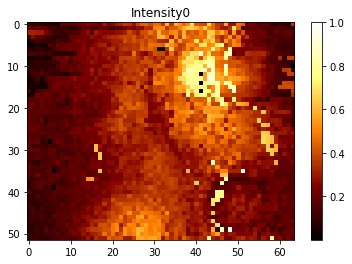

In [754]:
plotFitRev(2)

In [27]:
def fitSpectraRev(rangeLow,rangeHigh):
    '''fit all reverse spectra to test_func and store fit params in rows of allParamsFor array'''
    global allParamsRev
    global wavelength
    allParamsRev = []
    x_data = wavelength[rangeLow:rangeHigh]
    for i in range(0,len(reverseInt)):
        try:
            y_data = reverseInt[i][rangeLow:rangeHigh]
            params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,p0=initParams,sigma=None,absolute_sigma=False,check_finite=True,bounds=paramBounds)
            allParamsRev.append(params)
        except RuntimeError:
            allParamsRev.append([0,0,0,0,0,0,0])
            print(i)
    return print('finished fitting!')

In [ ]:
fitSpectraRev(rangeL, rangeH)

In [ ]:
def plotFitRev(dataName):
    '''generates heat map of fit parameters at each pixel for reverse scan and saves each image as a png.'''
    global revPos
    global revInt
    global revWid
    global revIntNorm
    %matplotlib inline
    revInt = np.empty([scanSize,scanSize])
    revPos = np.empty([scanSize,scanSize])
    revWid = np.empty([scanSize,scanSize])
    from PIL import Image
    for i in range(0,scanSize):
        for j in range(0,scanSize):
            revInt[i][-j-1]=allParamsRev[j+i*scanSize][0]
            revPos[i][-j-1]=allParamsRev[j+i*scanSize][1]
            revWid[i][-j-1]=allParamsRev[j+i*scanSize][2]
    #normalize reverse and reverse intensities to an intensity of 1
    revIntNorm = revInt/np.amax(forInt)
    # Make reverse intensity image
    fig, ax = plt.subplots()
    cax = ax.imshow(revIntNorm, interpolation='nearest', cmap=cm.afmhot)
    ax.set_title('Intensity')
    # Add colorbar, specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax)
    revIntStr = 'spectra/revInt'+ fileName + '_' + dataName +'.png'
    revIntStr1 = 'spectra/revInt'+ fileName + '_' + dataName
    plt.savefig(revIntStr)
    test1 = []
    for i in range(0, 4096):
               test1.append(allParamsRev[i][0])
    write_gsf(revIntStr1, test1, 64, 64,
              xreal=None, yreal=None, xyunits=None, zunits=None, title=None)
    #make reverse peak position image
    fig, ax = plt.subplots()
    cax = ax.imshow(revPos, interpolation='nearest', cmap=cm.afmhot)
    ax.set_title('Peak Position')
    # Add colorbar, specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax)
    revPosStr = 'spectra/revPos'+ fileName + '_' + dataName +'.png'
    revPosStr1 = 'spectra/revPos'+ fileName + '_' + dataName
    plt.savefig(revPosStr)
    test2 = []
    for i in range(0, 4096):
               test2.append(allParamsRev[i][1])
    write_gsf(revPosStr1, test2, 64, 64,
              xreal=None, yreal=None, xyunits=None, zunits=None, title=None)
    #make forward peak width image
    fig, ax = plt.subplots()
    cax = ax.imshow(revWid, interpolation='nearest', cmap=cm.afmhot)
    ax.set_title('Peak Width')
    # Add colorbar, specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax)
    revWidStr = 'spectra/revWid'+ fileName + '_' + dataName +'.png'
    revWidStr1 = 'spectra/revWid'+ fileName + '_' + dataName
    plt.savefig(revWidStr)
    test3 = []
    for i in range(0, 4096):
               test3.append(allParamsRev[i][2])
    write_gsf(revWidStr1, test3, 64, 64,
              xreal=None, yreal=None, xyunits=None, zunits=None, title=None)
    plt.show()

In [ ]:
plotFitRev(str(datetime.datetime.now().date()))